In [1]:
from IPython.display import clear_output

In [2]:
# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install numpy
%pip install scikit-learn
%pip install matplotlib
%pip install tqdm

clear_output()

In [3]:
import math
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#Contents:

1. Scratch implementation of Logistic Regression using numpy on custom data
2. Sklearn implementation of Logistic Regression on IRIS dataset


You need to know:

1. **numpy** (for impelementation)
2. a little bit of **matplotlib** (for visualization)


Good to have knowledge of:

1. Sklearn (details of the functions is given anyways)

Before we get to coding, Here's are the equations for logistic regression cost function (cross-entropy) and sigmoid function

Cost function:

$$
Cross-Entropy-Loss = -\left( y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right)
$$

Sigmoid:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [4]:
def sigmoid(z):
  '''
    Appliy the sigmoid function.
    The sigmoid function returns the output from 0 to 1
  '''
  return 1 / (1 + np.exp(-z))

In [5]:
def log_reg_cost(y, y_hat):
  '''
    This function caleculate and return the loss of the logistic regression.

    Function is slightly different from mentioned above because this one handles batched/vector/multiple inputs (rather than just one).
    This function sums and takes average across the vector.
  '''
  return -1/len(y) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

In [6]:
def log_reg_gradient_descent(X, y, learning_rate, num_iters= 500):
  '''
    This function take the data set as input and returns optimized weights.
  '''

  m, n = X.shape # m: The number of data samples (rows) in the dataset X, while n: The number of features (columns) in the dataset X.

  theta = np.zeros(n) # the weights (or parameters) of the logistic regression model one weight per feature).

  losses = []

  for _ in tqdm(range(num_iters)):
    # Forward Pass:
    # This is where the model predicts outputs (y_hat) using the current weights (theta).
    z = np.dot(X, theta) # The linear combination of inputs and weights for all data samples.
    y_hat = sigmoid(z)

    # Backward Pass:
    # This is where the model computes the error and adjusts the weights to minimize it.
    gradient = np.dot(X.T, (y_hat - y)) / m # the derivative of the loss function with respect to the weights theta.
                                            # It tells how much and in what direction to adjust the weights.

    # This adjusts the weights (theta) by moving them in the direction that reduces the loss.
    theta -= learning_rate * gradient

    # caleculate the loss
    loss = log_reg_cost(y, y_hat)
    losses.append(loss)

  plt.plot(losses)

  return theta

In [7]:
def predict(X, theta, threshold=0.5):
    '''Predict using the learned weights.'''
    probabilities = sigmoid(np.dot(X, theta))
    return (probabilities >= threshold).astype(int)

# Let's build a custom dataset for our logistic regression model

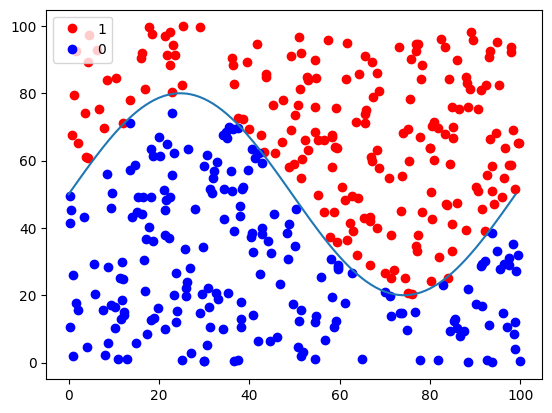

In [8]:
# Let's build a custom dataset for our logistic regression model

n_points = 400  # num of points in generated data
max_coordinate_value = 100  # max possible value taken by the x or y coordinate of a point

points = np.random.rand(n_points, 2) * max_coordinate_value

l = np.sin(2*math.pi*(points[:, 0]/max_coordinate_value))
l = (l*0.3*max_coordinate_value)+(max_coordinate_value/2)
mask = points[:, 1] > l

labels = np.zeros(n_points)
labels[mask] = 1

divider = (30 * np.sin(2*math.pi*np.linspace(0, max_coordinate_value, max_coordinate_value)/max_coordinate_value))
divider = max_coordinate_value/2 + divider

plt.plot(points[mask][:, 0], points[mask][:, 1], 'ro', label='1')
plt.plot(points[~mask][:, 0], points[~mask][:, 1], 'bo', label='0')
plt.plot(divider)  # visualization only

plt.legend()
plt.show()

In [9]:
# rename to X and y.

X = points
y = labels

print(f'Current X shape: {X.shape}')

intercept_col = np.ones(X.shape[0])  # a column of 1's for intercept value (b).
X = np.column_stack((X, intercept_col)) # we stack it here to learn it also.

print(f'New X shape: {X.shape}. Extra col added for intercept value')

Current X shape: (400, 2)
New X shape: (400, 3). Extra col added for intercept value


100%|██████████| 30000/30000 [00:01<00:00, 15681.47it/s]


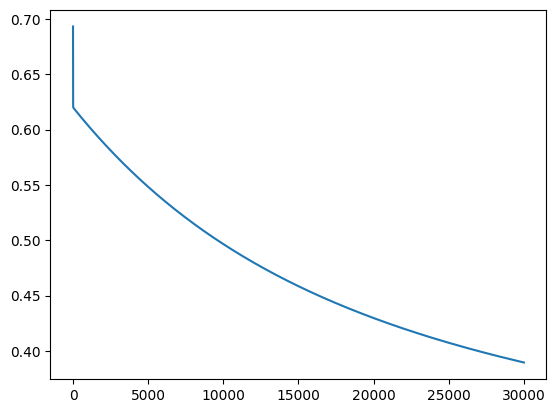

In [10]:
# Run Optimization

num_iters = 30000 # Design choice.
lr = 1e-3 # Design choice.

theta = log_reg_gradient_descent(X, y, lr, num_iters)

In [11]:
y_pred = sigmoid(np.dot(X, theta))  # here we compute z and pass it to the sigmoid function, the output of sigmoid is in range 0-1
y_pred = np.round(y_pred)  # round to 0 or 1

''' Why Round?
    The sigmoid output is a probability (a value between 0 and 1).
    Logistic regression is a binary classification algorithm, so we need to assign each prediction to either class 0 or 1.

    Probabilities ≥ 0.5 to 1.
    Probabilities < 0.5 to 0.
'''

correct_mask = (y_pred == y)
correct_count = correct_mask.sum()
total_count = len(y_pred)

print(f'The model predicted {correct_count} out of {total_count} predictions correctly')
print(f'The Accuracy is {correct_count/total_count} ({correct_count/total_count*100}%)')

The model predicted 338 out of 400 predictions correctly
The Accuracy is 0.845 (84.5%)


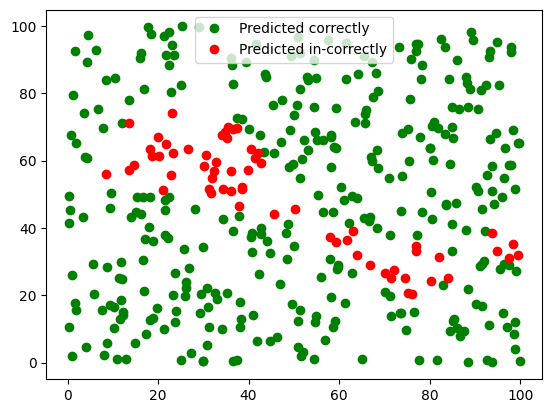

In [12]:
plt.plot(X[correct_mask][:, 0], X[correct_mask][:, 1], 'go', label='Predicted correctly')
plt.plot(X[~correct_mask][:, 0], X[~correct_mask][:, 1], 'ro', label='Predicted in-correctly')

plt.legend()
plt.show()

Before we move on, let's also take a look at confusion matrix

confusion matrix shows us the following:

```
TP FP
FN TN
```

i.e

- True Positive: How many actual labels were positive and were predicted positive too (the model predicted right)
- False Positive: How many actual labels were negative but were predicted positive
- False Negative: How many actual labels were positive but were predicted negative
- True Negative: How many actual labels were negative and were predicted negative (the model predicted right)

In [13]:
confusion_matrix(y, y_pred)

array([[159,  45],
       [ 17, 179]])

Sklearn implementation
Also, let's try it on a famous dataset

We'll work with Iris dataset.

About Iris
The dataset is about classfying flowers based on length of their parts. There are more than 3 classes in it but we'll just pick a class and predict wether a flower IS that class or ISN'T

train test split
We'll also seperate the test data out of training data, a common practice in when training models to see their performance

In [14]:
# let's load iris and have a look at it

iris_data = load_iris()  # returns a dict
print(iris_data.keys(), '\n')

print('given features:', iris_data['feature_names'])
print('flower names (class names):', iris_data['target_names'])

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module']) 

given features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
flower names (class names): ['setosa' 'versicolor' 'virginica']


In [15]:
# Those are the given details. We're  concerned about 'data' (containing features of flowers) and target (containing classes)

X = np.array(iris_data['data'])
y = np.array(iris_data['target'])

# Data is sorted by y. Let's shake things up a bit

shuffled_idxs = list(range(0, len(y)))
np.random.shuffle(shuffled_idxs)

X = X[shuffled_idxs]
y = y[shuffled_idxs]

'''
Why Shuffling the Data?
to prevent Bias During Training and Testing.
'''

In [16]:
y

array([2, 0, 2, 1, 2, 2, 0, 1, 2, 0, 2, 0, 1, 2, 2, 0, 2, 2, 1, 2, 1, 0,
       2, 2, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 2, 0, 0, 2, 2, 1, 0, 1, 2,
       1, 1, 2, 1, 0, 0, 0, 1, 1, 2, 2, 2, 1, 0, 1, 0, 2, 2, 1, 1, 2, 0,
       2, 0, 0, 0, 2, 1, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 2, 0,
       0, 2, 0, 2, 1, 0, 0, 2, 1, 1, 1, 0, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2,
       0, 2, 1, 1, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 1, 0, 2,
       2, 1, 2, 2, 2, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0])

In [17]:
print(X.shape)
print(y.shape)

print(np.unique(y))

(150, 4)
(150,)
[0 1 2]


In [18]:
# The next step after getting your hands on a dataset might normally be EDA, but we'll skip that.
# we'll make a logistic regression model for class '0' (named setosa). The model returns 1 for flower IS setosa and 0 for flower is NOT setosa

y[y==0]  = -1  # placeholder value
y[y>0]   =  0
y[y==-1] =  1  # Setosa labels are now 1 in 'y' and other flower's are 0

In [19]:
y  # 0 is replaced with 1 and non-0 are now 0

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1])

xplanation of train_test_split

The function is used to seperate out train and test data so we can train on different data and evaluate on different data.

Stratify: the shuffle will be made in such a way that the column specified in stratify will have equal distribution of different values in train and test splits. In our case, 1/3 of total data is 1 and 2/3 of data is 0. Stratifying by y means that this will be the case for y_train and y_test as well.
random_state: normally, split are made randomly but specifying a state means this cell will make the same split everytime.
train_size: how much of the data (out of 1) is kept as training. 0.7 means 70% data goes to training and 30% goes to testing

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123, train_size=0.7)

In [21]:
model = LogisticRegression()
model.fit(X_train, y_train)  # we train on training data only

LogisticRegression()

In [22]:
y_pred = model.predict(X_test)  # to check the performance, we use the testing data split

In [23]:
correct_mask = (y_pred == y_test)  # the predictions from testing features is supposed to be compared to labels of testing data
correct_count = correct_mask.sum()
total_count = len(y_pred)

print(f'The model predicted {correct_count} out of {total_count} predictions')
print(f'The Accuracy is {correct_count/total_count} ({correct_count/total_count*100}%)')

The model predicted 45 out of 45 predictions
The Accuracy is 1.0 (100.0%)


In [24]:
confusion_matrix(y_test, y_pred)

array([[30,  0],
       [ 0, 15]])

# Predicting the dataset with our model

100%|██████████| 1000/1000 [00:00<00:00, 5088.91it/s]


The model predicted 45 out of 45 predictions correctly.
The Accuracy is 1.00 (100.00%)
Confusion Matrix:
[[30  0]
 [ 0 15]]


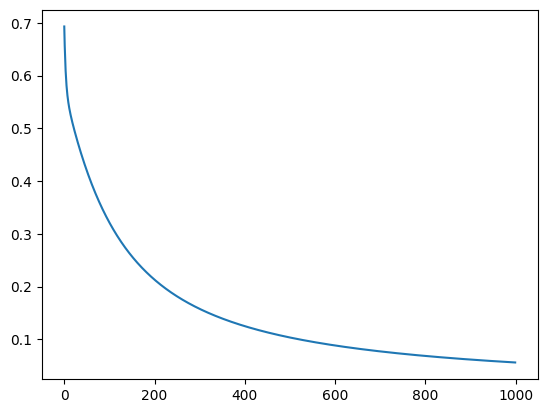

In [25]:
learning_rate = 0.01
num_iters = 1000
theta = log_reg_gradient_descent(X_train, y_train, learning_rate, num_iters)

# Predict on the test set
y_pred = predict(X_test, theta)

# Evaluate the model
correct_mask = (y_pred == y_test)
correct_count = correct_mask.sum()
total_count = len(y_pred)
accuracy = correct_count / total_count
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f'The model predicted {correct_count} out of {total_count} predictions correctly.')
print(f'The Accuracy is {accuracy:.2f} ({accuracy * 100:.2f}%)')
print('Confusion Matrix:')
print(conf_matrix)